Learning Computer Vision with Python 3 --  Section 4  
<b>Deep learning image classification with Tensorflow</b>

What is a tensor?

From Wikipedia:
https://en.wikipedia.org/wiki/Tensor

"In mathematics, tensors are geometric objects that describe linear relations between geometric vectors, scalars, and other tensors....Given a reference basis of vectors, a tensor can be represented as an organized multidimensional array of numerical values. 
"

According to Google:

A tensor is a multidimensional array.  Though it can be of any dimension and have any data type.  So, per Google, a tensor is anything you want it to be, at least anything that is representable as computer data.  (Put another way, the word is pretty much meaningless now.)

Tensorflow is a high-performance numerical library.  It is primarily geared towards machine learning, though it is also useful for general purpose numerical computing such as physical simulations and solving partial differential equations.

In [1]:
#Get started with needed libraries/settings/directory
%pylab inline
%cd /home/test/13293/chapter7/

import tensorflow as tf
import numpy as np

Populating the interactive namespace from numpy and matplotlib
/home/test/13293/chapter7


<b>Basic Tensorflow workflow examples</b>

In [3]:
#Arithmetic with Tensorflow

a = tf.constant(2)
b = tf.constant(3)

with tf.Session() as sess:
    print("a=2, b=3")
    print("a+b=" + str(sess.run(a+b)))
    print("a*b=" + str(sess.run(a*b)))

a = tf.placeholder(tf.int16)
b = tf.placeholder(tf.int16)

add = tf.add(a, b)
mul = tf.multiply(a, b)

with tf.Session() as sess:
    print("a+b=" + str(sess.run(add, feed_dict={a: 2, b: 3})))
    print("a*b=" + str(sess.run(mul, feed_dict={a: 2, b: 3})))

a=2, b=3
a+b=5
a*b=6
a+b=5
a*b=6


In [5]:
#Matrix multiplication
matrix1 = tf.constant([[1., 2.],[9.0,3.14159]])
matrix2 = tf.constant([[3.],[4.]])

product = tf.matmul(matrix1, matrix2)

with tf.Session() as sess:
    result = sess.run(product)
    print(result)

[[11.     ]
 [39.56636]]


In [4]:
#creating a convolutional neural network (skeleton--not complete code!)

# create a convolutional (not fully connected) layer...
conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
# and downsample
conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

# create second layer
conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

# flatten to 1D
fc1 = tf.contrib.layers.flatten(conv2)

# create fully-connected layer
fc1 = tf.layers.dense(fc1, 1024)


# final (output/prediction) layer
out = tf.layers.dense(fc1, n_classes)

#...training code etc.

NameError: name 'x' is not defined

<b>Classifying images with a pretrained model (Inception)</b>

Needed file:
http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz

Unzip (thoroughly) the contents to get .txt, .pbtxt, and .pb files.  The .pb file contains the trained model for our classifier.


In [8]:
#The main code:
#"image" is a filename for the image we want to classify

#load our inception-id to English description dictionary
from inceptiondict import inceptiondict

def run_inference_on_image(image):

    #load image (making sure it exists)
    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
    image_data = tf.gfile.FastGFile(image, 'rb').read()

    # Load our "graph" file--
    # This graph is a pretrained model that maps an input image
    #  to one (or more) of a thousand classes.
    # Note: generating such a model from scratch is VERY computationally
    #       expensive
    with tf.gfile.FastGFile('classify_image_graph_def.pb', 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
        
        
    #create a TF session to actually apply our model
    with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
        predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
        predictions = np.squeeze(predictions)
        
        #The output here is a 1000 length vector, each element between 0 and 1, 
        #that sums to 1.  Each element may be thought of as a probability
        #that the image corresponds to a given class (object type, e.g. bird, 
        #plane, etc).

        
        #We only care about the top 5 (at most) predictions, and ones that have
        #at least a 10% probability of a match
        num_top_predictions= 5
        top_k = predictions.argsort()[-num_top_predictions:][::-1]
        for node_id in top_k:
            human_string = inceptiondict[node_id]
            score = predictions[node_id]
            if score > 0.1:
                print('%s (score = %.5f)' % (human_string, score))

ImportError: cannot import name 'inceptiondict'

Irish wolfhound (score = 0.34313)
borzoi, Russian wolfhound (score = 0.17871)
Saluki, gazelle hound (score = 0.11669)


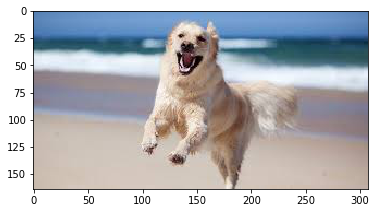

In [12]:
#uncomment out one of these lines to test

image='sample_imgs/cropped_panda.jpg'
# image='sample_imgs/dog.jpg'
# image='sample_imgs/bicycle2.jpg'
# image='sample_imgs/garbagecan.jpg'
# image='sample_imgs/bunny.jpg'
# image='sample_imgs/trombone.jpg'
# image='sample_imgs/treasurechest.jpg'
# image='sample_imgs/hotdog.jpg'
figure()
imshow(imread(image))
run_inference_on_image(image)

<b>Training on our own images and creating custom detection classes</b>

First, we need to acquire and organize our images.
Simple way to get started, download:
http://download.tensorflow.org/example_images/flower_photos.tgz
and completely unzip.

Then in the cell below, substitute the parameter in 'retrain' with the 'flower_photos' directory.

Otherwise, put your own files in a subfolder. Each subfolder of the subfolder will be named with the class name you want to give it (eg "dog", "cat", "plane"...).

For our example here, I created a directory called 'toy_images'.  There are four subfolders called 'barbie', 'gi joe', 'my little pony', and 'transformers'.  Each folder contains images (>100) of toys of each type.  The file names are not important.

Make sure to pull out some images for testing.  You want to validate your model by running some images that weren't in the training set.

In [13]:
#pull the function from our custom retrain.py file
from retrain import retrain

#Now we'll train our model and generate our model/graph file 'output_graph.pb'
retrain('toy_images')

Retraining with images in directory: toy_images
Converted 378 variables to const ops.


In [14]:
#Confirm that it worked
!ls *.pb

#should see file "output_graph.pb"

classify_image_graph_def.pb
output_graph - Copy.pb
output_graph.pb


In [16]:
#Let's load some code that will run our model on a specified image

def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph


def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(
                file_reader, channels=3, name="png_reader")
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(
                tf.image.decode_gif(file_reader, name="gif_reader"))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
    else:
        image_reader = tf.image.decode_jpeg(
                file_reader, channels=3, name="jpeg_reader")
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0)
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)

    return result


def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label


def label_image(file_name=None):
    if not file_name:
        file_name = "test/mylittlepony2.jpg"
    model_file = "./output_graph.pb"
    label_file = "./output_labels.txt"
    input_height = 299
    input_width = 299
    input_mean = 0
    input_std = 255
    input_layer = "Placeholder"
    output_layer = "final_result"


    graph = load_graph(model_file)
    t = read_tensor_from_image_file(
            file_name,
            input_height=input_height,
            input_width=input_width,
            input_mean=input_mean,
            input_std=input_std)

    input_name = "import/" + input_layer
    output_name = "import/" + output_layer
    input_operation = graph.get_operation_by_name(input_name)
    output_operation = graph.get_operation_by_name(output_name)

    with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: t
        })
    results = np.squeeze(results)

    top_k = results.argsort()[-5:][::-1]
    labels = load_labels(label_file)
    for i in top_k:
        print(labels[i], results[i])


barbie 0.98703706
transformers 0.0064564478
my little pony 0.005074826
gi joe 0.0014316614


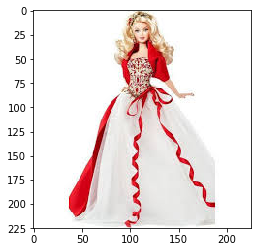

In [24]:
#label_image will load our test image and tell us what class/type it is

#uncomment one of these lines to test
#
# test_image='test/transformers1.jpg'
# test_image='test/transformers2.jpg'
# test_image='test/transformers3.jpg'

# test_image='test/mylittlepony1.jpg'
# test_image='test/mylittlepony2.jpg'
# test_image='test/mylittlepony3.jpg'

# test_image='test/gijoe1.jpg'
# test_image='test/gijoe2.jpg'
# test_image='test/gijoe3.jpg'

# test_image='test/barbie1.jpg'
# test_image='test/barbie2.jpg'
test_image='test/barbie3.jpg'

#display the image
figure()
imshow(imread(test_image))

#and tell us what the classification result is
label_image(test_image)